![MAIA banner](https://raw.githubusercontent.com/MAIA4361-Aprendizaje-refuerzo-profundo/Notebooks_Tareas/main/Images/Aprendizaje_refuerzo_profundo_Banner_V1.png)

# <h1><center>Tarea Tutorial - Semana 6 <a href="https://colab.research.google.com/github/SSolanoRuniandes/Notebooks-Aprendizaje-por-Refuerzo-Profundo/blob/main/TareaSemana6.ipynb"><img src="https://colab.research.google.com/assets/colab-badge.svg" width="140" align="center"/></a></center></h1>

<center><h1>PPO y TRPO</h1></center>

Este tutorial sigue con el estudio de algoritmos de gradiente de política. Concretamente, se revisarán 2 algoritmos: Trust Region Policy Optimization (TRPO) y Proximal Policy Optimization (PPO). Se utilizará la implementación de ambos algoritmos encontrada dentro de <a href="https://stable-baselines3.readthedocs.io/en/master/index.html">Stable Baselines3</a>, y los usaremos para resolver dos problemas de robótica basados en el entorno de simulación MuJoCo: <a href="https://gymnasium.farama.org/environments/mujoco/hopper/">Hopper</a> y <a href="https://gymnasium.farama.org/environments/mujoco/ant/">Ant</a>. Este notebook tutorial se divide en las siguientes secciones:


# Tabla de Contenidos
1. [Objetivos de Aprendizaje](#scrollTo=Objetivos_de_Aprendizaje)  
2. [Marco Teórico](#scrollTo=Marco_Te_rico)  
3. [Instalación de Librerías](#scrollTo=Instalaci_n_de_Librer_as)  
4. [Familiarización con los Entornos de Gym](#scrollTo=Familiarizaci_n_con_los_Entornos_de_Gym)
5. [Hopper](#scrollTo=Hopper)  
6. [Ant](#scrollTo=Ant)
7. [Entrenamiento de agentes PPO y TRPO para Hopper](#scrollTo=Entrenamiento_de_agentes_PPO_y_TRPO_para_Hopper)
8. [Entrenamiento de agentes PPO y TRPO para Ant](#scrollTo=Entrenamiento_de_agentes_PPO_y_TRPO_para_Ant)
8. [Reflexiones Finales](#scrollTo=Reflexiones_Finales)  
9. [Referencias](#scrollTo=Referencias)

# Objetivos de Aprendizaje  
  
* Comprender las bases teóricas detrás de algoritmos de gradiente de política basados en optimización restringida.
* Solucionar problemas de robótica basados en simulaciones físicas usando los algoritmos de TRPO y PPO.
* Comparar las ventajas y desventajas que existen entre TRPO y PPO.


# Marco Teórico  

Antes de explicar el funcionamiento concreto de los algoritmos de Trust Region Policy Optimization (TRPO) y Proximal Policy Optimization (PPO) es importante comprender el concepto de Divergencia de Kullback-Leibler, llamada abreviadamente como Divergencia KL. La Divergencia KL es una métrica que mide cuán diferente es una distribución de probabilidad de otra. Por ejemplo, si consideramos dos distribuciones de probabilidad genéricas $P_1(x)$ y $P_2(x)$, se define la Divergencia KL de la siguiente manera:

<center> $ D_{KL} = \sum_x P_1(x) \text{log}\left(\frac{P_1(x)}{P_2(x)}\right) $ &emsp;&emsp;&emsp;$(1)$ </center>

En la teoría del Aprendizaje por Refuerzo, la Divergencia KL se utiliza para comparar y medir la diferencia que existe entre una política antigua ($\pi_{old}$) y una política nueva ($\pi_{new}$). Una Divergencia KL pequeña indica que ambas políticas son parecidas, que no hubo grandes cambios en la actualización, mientras que una Divergencia KL grande indica que ambas políticas son muy diferentes entre sí.

En TRPO, si se denota al retorno descontado esperado como $\eta(\pi)$, y $L_{\pi_{old}}(\pi_{new})$ una aproximación local de $\eta$, se puede demostrar la siguiente cota:

<center> $ \eta(\pi_{new}) \geq L_{\pi_{old}}(\pi_{new}) - C \cdot D_{KL}^{max} (\pi_{old}, \pi_{new})$ &emsp;$ \text{donde} $ &emsp; $C = \frac{4 \epsilon \gamma}{(1-\gamma)^2} $&emsp;&emsp;&emsp;$(2)$ </center>

La Ecuación (2) muestra que mientras que la Divergencia KL se mantenga dentro de un límite, por debajo de un umbral pequeño $\delta$, se puede asegurar que el rendimiento no decrecerá, garantizando una mejora o por lo menos estabilidad. En pocas palabras, el algoritmo de TRPO busca solucionar el problema de optimización restringida dado por la Ecuación (3):

$$
\begin{aligned}
\max_{\theta}  & \ \ L_{\theta_{old}}(\theta) \\
\text{subject to}  & \ \ D_{KL}^{max} (\theta_{old}, \theta) \leq \delta \qquad \text{(3)}
\end{aligned}
$$

Dado que también se puede demostrar la equivalencia $D_{KL} (\pi_{\theta_{old}}, \pi_{\theta}) = D_{KL} (\theta_{old}, \theta)$. Expandiendo el término $L_{\theta_{old}}$, se puede reescribir la Ecuación (4). En esta expresión, se utiliza la notación $\rho$ para definir la frecuencia de visitas y $\hat{A}$ la ventaja.

$$
\begin{aligned}
\max_{\theta} \quad & \sum_s \rho_{\theta_{\text{old}}}(s) \sum_a \pi_{\theta}(a|s) \hat{A}_{\theta_{\text{old}}}(s, a) \\
\text{subject to} \quad & \bar{D}^{\rho^{\theta_{\text{old}}}}_{\mathrm{KL}}(\theta_{\text{old}}, \theta) \leq \delta \qquad \text{(4)}
\end{aligned}
$$

TRPO es en teoría fiable y robusto, pero en la práctica resulta difícil de implementar debido a este problema de optimización restringida, especialmente cuando la arquitectura de las redes nueronales se hace compleja. PPO ofrece una implementación más sencilla e igual o más estable que TRPO.

Primero, se define $r_t(\theta)$ como una razón de probabilidad:

<center> $ r_t(\theta) = \frac{\pi_{\theta}(a_t, s_t)}{\pi_{\theta_{old}}(a_t, s_t)} $ &emsp;&emsp;&emsp;$(5) $ </center>

Con esta definición, capaz de medir el cambio de probabilidad de una política respecto a la anterior, se puede también definir un objetivo "sustituto" de TRPO:

<center> $ L(\theta) = \hat{\mathbb{E}}_t \left[ \frac{\pi_{\theta}(a_t \mid s_t)}{\pi_{\theta_{\text{old}}}(a_t \mid s_t)} \hat{A}_t \right] = \hat{\mathbb{E}}_t \left[ r_t(\theta) \hat{A}_t \right] $ &emsp;&emsp;&emsp;$(6) $ </center>

La maximización del término $L(\theta)$ en la Ecuación (6) llevaría a una actualización demasiado grande de la política. Por ello, en PPO se considera cómo modificar este objetivo para penalizar cambios que muevan a $r_t(\theta)$ lejos de 1. La solución es aplicar un <i>clipping</i>, como se muestra en la Ecuación (7).

<center> $ L^{\text{CLIP}}(\theta) = \hat{\mathbb{E}}_t \left[ \min \left( r_t(\theta) \hat{A}_t,\ \text{clip}(r_t(\theta), 1 - \varepsilon, 1 + \varepsilon) \hat{A}_t \right) \right] $ &emsp;&emsp;&emsp;$(7) $ </center>

Donde $\epsilon$ es un hiperparámetro utilizado para modificar el rango de <i>clipping</i>. El primer término dentro de la función de minimización es la función $L(\theta)$ original de la Ecuación (6), y el segundo término modifica este valor recortando el rango de probabilidad, removiendo el incentivo de mover la razón $r_t(\theta)$ fuera del rango $[1-\varepsilon,1+\varepsilon]$. Al tomar el mínimo entre el objetivo original y recortado se obtiene un límite inferior más pesimista y estable. De esta manera, los cambios en la razón de probabilidades se ignora cuando el objetivo realmente mejora, y se tiene en cuenta cuando empeora. En resumen, el cambio es penalizado, no se sobreestima el beneficio y se tiene una aproximación pesimista más estable gracias al <i>clipping</i>.

# Instalación de Librerías  

Corra el siguiente bloque de código para instalar las librerías requeridas en el tutorial. Se encuentra incluído el módulo oficial de Stable Baselines3 que ejecuta PPO y TRPO, y los ambientes de Gymnasium que incluyen Hopper y Ant. Esta celda puede tardar un par de minutos en ejecutarse completamente la primera vez.


In [ ]:
# Instalación de dependencias del sistema
!apt update -y > /dev/null
!apt install -y xvfb ffmpeg > /dev/null

# Instalación de paquetes de Python (con Mujoco, extras y contrib)
!pip install -q gymnasium[mujoco] pyvirtualdisplay imageio[ffmpeg] stable-baselines3[extra] sb3-contrib


# Importación de librerías necesarias
from pyvirtualdisplay import Display
from IPython.display import HTML
from base64 import b64encode

import gymnasium as gym
import imageio
import torch
import numpy as np
import matplotlib.pyplot as plt
import os
import time

from stable_baselines3 import PPO
from sb3_contrib import TRPO
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.callbacks import BaseCallback

#Limpia los registros generados
from IPython.display import clear_output
clear_output()
print("Todas las librerías han sido instaladas correctamente.")

Todas las librerías han sido instaladas correctamente.


# Familiarización con los Entornos de Gym

Los siguientes ambientes de Gymnasium son entornos basados en MuJoCo de Google Deep Mind. MuJoCo (Multi-Joint dynamics with Contact) es un simulador físico utilizado para modelar y estudiar el comportamiento de sistemas dinámicos complejos, muy utilizado en robótica.




## Hopper

El ambiente de <a href="https://gymnasium.farama.org/environments/mujoco/hopper/">Hopper</a> consiste en una pierna en dos dimensiones que tiene como objetivo moverse hacia adelante modificando el torque de sus motores. Concretamente, la pierna se compone de cuatro partes: un torso en la parte superior, un muslo, una pantorrilla y un pie. Y cuenta con tres motores, uno para el muslo ubicado en la cadera, uno en la rodilla, y uno en el tobillo. Un diagrama esquemático del cuerpo y una imágen del entorno de simulación se muestran en la Figura 1.

![Action_space_hopper](https://raw.githubusercontent.com/MAIA4361-Aprendizaje-refuerzo-profundo/Notebooks_Tareas/main/Images/Action_space_hopper.png)

<center>Figura 1. Descripción del ambiente de Hopper. [4]</center>

Como se ve en la Figura 1, el espacio de acciones está descrito por el control de torque en los tres motores ubicados en las bisagras de la pierna. Los índices de los motores son respectivamente 0, 1 y 2, y el rango de control de cada motor se normaliza entre -1 y 1.

Por otro lado, el espacio de observación está descrito por 5 posiciones (<i>qpos</i>) y 6 velocidades (<i>qvel</i>) de las partes individuales del robot.

Finalmente, la recompensa es calculada ponderando 3 aspectos clave: la estabilidad del mecanismo por la cual recibe una recompensa de +1 por cada timestep en el cual la pierna no cae de cierta altura, la posición del torso que se usa para evaluar que la pierna avanza, y una penalización de control que castiga cuando se toman acciones muy grandes en los motores.  


### Ejemplo

En el siguiente bloque de código se muestra un ejemplo de cómo se simula un episodio del Hopper. En este caso se está realizando una acción aleatoria en cada interacción con el ambiente.

In [ ]:
# Iniciar una pantalla virtual (necesaria en Colab o en entornos sin interfaz gráfica)
display = Display(visible=0, size=(1400, 900))
display.start()

# Crear el entorno Hopper con renderizado en modo RGB (imagen)
env = gym.make("Hopper-v5", render_mode="rgb_array")
obs, info = env.reset()

frames = []  # Lista para almacenar los fotogramas del video
terminated = truncated = False
total_reward = 0  # Acumulador de la recompensa total

# Ejecutar el entorno hasta que termine o se trunque
while not (terminated or truncated):
    action = env.action_space.sample()  # Tomar una acción aleatoria del espacio de acciones
    obs, reward, terminated, truncated, info = env.step(action)  # Aplicar la acción al entorno
    frame = env.render()  # Renderizar el entorno y capturar el fotograma
    frames.append(frame)  # Guardar el fotograma
    total_reward += reward  # Acumular la recompensa

env.close()  # Cerrar el entorno

# Guardar el video como archivo MP4
imageio.mimsave("hopper_video.mp4", frames, fps=30)
print("Total reward:", total_reward)  # Imprimir la recompensa total obtenida


Total reward: 13.020289658931377


Esta celda es la que se encarga de permitir la visualización del video en el entorno de Colab.

In [ ]:
mp4 = open("/content/hopper_video.mp4", "rb").read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()

HTML(f"""
<video width=600 controls>
    <source src="{data_url}" type="video/mp4">
</video>
""")


## Ant

El ambiente de <a href="https://gymnasium.farama.org/environments/mujoco/ant/">Ant</a> consiste en un robot cuadrúpedo formado por un torso con forma esférica y cuatro piernas con 2 partes cada una. En total el robot cuenta con 8 motores, y el objetivo de esta "hormiga" es moverse hacia adelante (dirección derecha de la simulación).

![Action_space_hopper](https://raw.githubusercontent.com/MAIA4361-Aprendizaje-refuerzo-profundo/Notebooks_Tareas/main/Images/Action_space_ant.png)

<center>Figura 2. Descripción del ambiente de Ant. [5]</center>

De forma similar a Hopper, en Ant el espacio de acciones está dado por el control de torque entre -1 y 1 de los 8 motores del sistema dinámico de acuerdo con los índices de la Figura 2.

En este caso, el espacio de observación está descrito por 13 posiciones (<i>qpos</i>) y 14 velocidades (<i>qvel</i>) de las partes del robot, y 78 elementos adicionales relacionados con el centro de masa y fuerzas externas al sistema.

La recompensa es calculada ponderando 4 aspectos. Al igual que en Hopper, en Ant se le da una recompensa en cada timestep por conservar la estabilidad, también se recompensa que el robot avance en la dirección deseada, y se penalizan acciones muy grandes. El cuarto elemento involucrado en este ambiente corresponde a un castigo si las fuerzas de contacto externas son demasiado grandes.

### Ejemplo

En el siguiente bloque de código se muestra un ejemplo de cómo se simula un episodio del Ant. En este caso se está realizando una acción aleatoria en cada interacción con el ambiente.

In [ ]:
# Iniciar una pantalla virtual (necesaria en Colab o en entornos sin interfaz gráfica)
display = Display(visible=0, size=(1400, 900))
display.start()

# Crear el entorno Ant con renderizado en modo RGB (imagen)
env = gym.make("Ant-v5", render_mode="rgb_array")
obs, info = env.reset()

frames = []  # Lista para almacenar los fotogramas del video
terminated = truncated = False
total_reward = 0  # Acumulador de la recompensa total

# Ejecutar el entorno hasta que termine o se trunque
while not (terminated or truncated):
    action = env.action_space.sample()  # Tomar una acción aleatoria del espacio de acciones
    obs, reward, terminated, truncated, info = env.step(action)  # Aplicar la acción al entorno
    frame = env.render()  # Renderizar el entorno y capturar el fotograma
    frames.append(frame)  # Guardar el fotograma
    total_reward += reward  # Acumular la recompensa

env.close()  # Cerrar el entorno

# Guardar el video como archivo MP4
imageio.mimsave("ant_video.mp4", frames, fps=30)
print("Total reward:", total_reward)  # Imprimir la recompensa total obtenida


Total reward: -14.564947247129519


Esta celda es la que se encarga de permitir la visualización del video en el entorno de Colab.

In [ ]:
mp4 = open("/content/ant_video.mp4", "rb").read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()

HTML(f"""
<video width=600 controls>
    <source src="{data_url}" type="video/mp4">
</video>
""")

# Entrenamiento de agentes PPO y TRPO para Hopper

En la siguiente celda de código se encuentra la clase encargada del entrenamiento de agentes para el ambiente de Hopper

In [ ]:
# Clase personalizada para registrar las recompensas por episodio durante el entrenamiento
class RewardLoggerCallback(BaseCallback):
    def __init__(self):
        super().__init__()
        self.episode_rewards = []  # Lista para almacenar las recompensas por episodio
        self.episode_reward = 0    # Acumulador de recompensa para el episodio actual

    def _on_step(self) -> bool:
        # Si hay recompensas disponibles en el paso actual, se suman al acumulador
        if "rewards" in self.locals:
            self.episode_reward += self.locals["rewards"][0]
        # Si el episodio ha terminado, se guarda la recompensa acumulada y se reinicia el contador
        if "dones" in self.locals and self.locals["dones"][0]:
            self.episode_rewards.append(self.episode_reward)
            self.episode_reward = 0
        return True


# Clase para entrenar un agente en el entorno Hopper
class HopperTrainer:
    def __init__(self, model_fn, total_timesteps=130_000, log_dir="./hopper_logs"):
        self.total_timesteps = total_timesteps
        self.log_dir = log_dir
        os.makedirs(log_dir, exist_ok=True)  # Crear el directorio de logs si no existe

        # Iniciar una pantalla virtual (necesaria en Colab o entornos sin interfaz gráfica)
        self.display = Display(visible=0, size=(1400, 900))
        self.display.start()

        # Crear el entorno Hopper vectorizado
        self.env = make_vec_env("Hopper-v5", n_envs=1)

        # Crear el modelo usando la función proporcionada
        self.model = model_fn(self.env)

        # Inicializar el callback para registrar recompensas
        self.callback = RewardLoggerCallback()


    def train(self, save_path="ppo_hopper_model"):
        print("GPU available?", torch.cuda.is_available())
        if torch.cuda.is_available():
            print("Using device:", torch.cuda.get_device_name(0))

        start_time = time.time()
        # Entrenar el modelo con el número total de pasos y el callback
        self.model.learn(total_timesteps=self.total_timesteps, callback=self.callback)
        elapsed = time.time() - start_time

        # Guardar el modelo entrenado
        self.model.save(save_path)
        print(f"Training complete. Model saved. Training took {elapsed:.2f} seconds.")

    def plot_rewards(self):
        # Verificar si hay datos de recompensa para graficar
        if not self.callback.episode_rewards:
            print("No reward data to plot.")
            return
        # Graficar las recompensas por episodio
        plt.figure(figsize=(10, 5))
        plt.plot(self.callback.episode_rewards, label="Episode Reward")
        plt.xlabel("Episodes")
        plt.ylabel("Reward")
        plt.title("Training Rewards Over Time")
        plt.grid()
        plt.legend()
        plt.tight_layout()
        plt.show()

    def generate_video(self, model, video_filename="hopper_video.mp4"):
        # Crear entorno Hopper con renderizado RGB
        env = gym.make("Hopper-v5", render_mode="rgb_array")
        obs, info = env.reset()
        frames = []
        total_reward = 0
        terminated = truncated = False

        # Ejecutar el entorno hasta que termine
        while not (terminated or truncated):
            action, _ = model.predict(obs, deterministic=True)  # Predecir acción
            obs, reward, terminated, truncated, info = env.step(action)
            frame = env.render()  # Capturar fotograma
            frames.append(frame)
            total_reward += reward

        env.close()

        # Guardar el video como archivo MP4
        imageio.mimsave(video_filename, frames, fps=30)
        print("Total reward:", total_reward)

        # Mostrar el video en Colab
        mp4 = open(video_filename, "rb").read()
        data_url = "data:video/mp4;base64," + b64encode(mp4).decode()

        return HTML(f"""
        <video width=600 controls>
            <source src="{data_url}" type="video/mp4">
        </video>
        """)


## Ejemplo

En la siguiente celda se muestra el entrenamiento y los resultados para un agente PPO durante 300000 interacciones con el ambiente

In [ ]:
def create_model(env):
    return PPO(
        "MlpPolicy",
        env,
        verbose=1,
        device="cpu"
    )

trainer = HopperTrainer(model_fn=create_model, total_timesteps=300_000)
trainer.train()

Using cpu device
GPU available? False
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20.2     |
|    ep_rew_mean     | 15.3     |
| time/              |          |
|    fps             | 753      |
|    iterations      | 1        |
|    time_elapsed    | 2        |
|    total_timesteps | 2048     |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 26.5        |
|    ep_rew_mean          | 25.6        |
| time/                   |             |
|    fps                  | 650         |
|    iterations           | 2           |
|    time_elapsed         | 6           |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.013594342 |
|    clip_fraction        | 0.168       |
|    clip_range           | 0.2         |
|    entropy_loss         | -4.23       |
|    explained_variance   | 0.0385

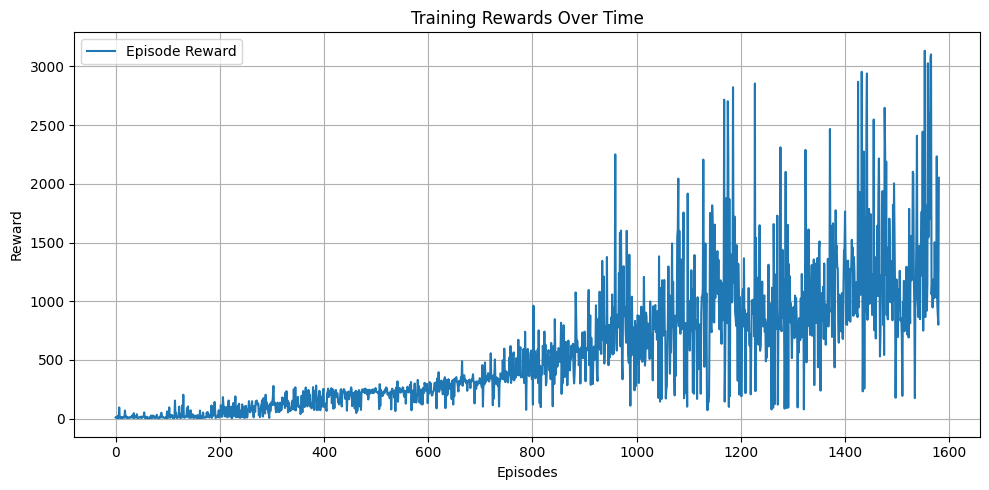

Total reward: 1506.9170660421046


In [ ]:
trainer.plot_rewards()
model = PPO.load("ppo_hopper_model")
trainer.generate_video(model,video_filename='ppo_hopper_video.mp4')

**IMPORTANTE: ESTE ENTRENAMIENTO TARDÓ ALREDEDOR DE 9 MINUTOS (300000 TIMESTEPS), Y GENERAR EL VIDEO TARDÓ ALREDEDOR DE 4 MINUTOS!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!**

## Ejercicio práctico

In [ ]:
#Completar-----------------------------------------------------------------

def create_model(env):
    return TRPO(
      #Completar---------------------------------------------------------
    )

trainer = HopperTrainer(model_fn=create_model, total_timesteps=)
trainer.train(save_path='trpo_hopper_model')

In [ ]:
trainer.plot_rewards()
model = TRPO.load("trpo_hopper_model")
trainer.generate_video(model,video_filename='trpo_hopper_video.mp4')

# Entrenamiento de agentes PPO y TRPO para Ant

En la siguiente celda de código se encuentra la clase encargada del entrenamiento de agentes para el ambiente de Hopper

In [ ]:
class AntTrainer:
    def __init__(self, model_fn, total_timesteps=130_000, log_dir="./ant_logs"):
        self.total_timesteps = total_timesteps
        self.log_dir = log_dir
        os.makedirs(log_dir, exist_ok=True)  # Crea el directorio de logs si no existe

        # Virtual display
        self.display = Display(visible=0, size=(1400, 900))  # Inicia una pantalla virtual (útil para entornos sin GUI)
        self.display.start()

        # Create environment
        self.env = make_vec_env("Ant-v5", n_envs=1)  # Crea el entorno vectorizado de Gymnasium

        # Create model using the provided function
        self.model = model_fn(self.env)  # Inicializa el modelo usando la función pasada como argumento

        # Reward logging
        self.callback = RewardLoggerCallback()  # Callback personalizado para registrar recompensas

    def train(self, save_path="ppo_ant_model"):
        print("GPU available?", torch.cuda.is_available())  # Verifica si hay GPU disponible
        if torch.cuda.is_available():
            print("Using device:", torch.cuda.get_device_name(0))  # Muestra el nombre de la GPU

        start_time = time.time()
        self.model.learn(total_timesteps=self.total_timesteps, callback=self.callback)  # Entrena el modelo
        elapsed = time.time() - start_time

        self.model.save(save_path)  # Guarda el modelo entrenado
        print(f"Training complete. Model saved. Training took {elapsed:.2f} seconds.")  # Muestra duración del entrenamiento

    def plot_rewards(self):
        if not self.callback.episode_rewards:
            print("No reward data to plot.")  # Verifica si hay datos de recompensa
            return
        plt.figure(figsize=(10, 5))
        plt.plot(self.callback.episode_rewards, label="Episode Reward")  # Grafica las recompensas por episodio
        plt.xlabel("Episodes")
        plt.ylabel("Reward")
        plt.title("Training Rewards Over Time")
        plt.grid()
        plt.legend()
        plt.tight_layout()
        plt.show()

    def generate_video(self, model, video_filename="ant_video.mp4"):
        env = gym.make("Ant-v5", render_mode="rgb_array")  # Crea el entorno con renderizado en modo imagen
        obs, info = env.reset()
        frames = []
        total_reward = 0
        terminated = truncated = False

        while not (terminated or truncated):
            action, _ = model.predict(obs, deterministic=True)  # Predice la acción usando la política entrenada
            obs, reward, terminated, truncated, info = env.step(action)  # Ejecuta la acción en el entorno
            frame = env.render()  # Captura el frame actual
            frames.append(frame)
            total_reward += reward  # Acumula la recompensa

        env.close()

        # Save video
        imageio.mimsave(video_filename, frames, fps=30)  # Guarda los frames como video
        print("Total reward:", total_reward)

        # Mostrar el video en Colab
        mp4 = open(video_filename, "rb").read()
        data_url = "data:video/mp4;base64," + b64encode(mp4).decode()

        return HTML(f"""
        <video width=600 controls>
            <source src="{data_url}" type="video/mp4">
        </video>
        """)

## Ejemplo

En la siguiente celda se muestra el entrenamiento y los resultados para un agente TRPO durante 300000 interacciones con el ambiente

In [ ]:
def create_model(env):
    return TRPO(
        "MlpPolicy",
        env,
        verbose=1,
        device="cpu"
    )

trainer = AntTrainer(model_fn=create_model, total_timesteps=300_000)
trainer.train(save_path='trpo_ant_model')

Using cpu device
GPU available? False
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 46.6     |
|    ep_rew_mean     | -52.8    |
| time/              |          |
|    fps             | 795      |
|    iterations      | 1        |
|    time_elapsed    | 2        |
|    total_timesteps | 2048     |
---------------------------------
----------------------------------------
| rollout/                  |          |
|    ep_len_mean            | 67.1     |
|    ep_rew_mean            | -72.2    |
| time/                     |          |
|    fps                    | 731      |
|    iterations             | 2        |
|    time_elapsed           | 5        |
|    total_timesteps        | 4096     |
| train/                    |          |
|    explained_variance     | -0.0133  |
|    is_line_search_success | 1        |
|    kl_divergence_loss     | 0.00452  |
|    learning_rate          | 0.001    |
|    n_updates              | 1        |
|    po

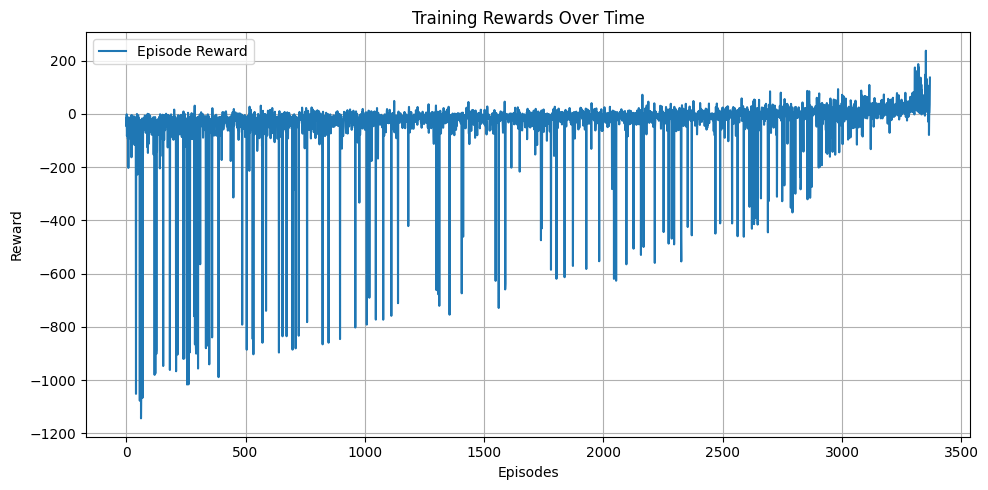

Total reward: 202.15171654792454


In [ ]:
trainer.plot_rewards()
model =TRPO.load("trpo_ant_model")
trainer.generate_video(model,video_filename='trpo_ant_video.mp4')

## Ejercicio práctico

In [ ]:
#Completar--------------------------------------------------------------------

def create_model(env):
    return PPO(
      #Completar---------------------------------------------------------------
    )

trainer = AntTrainer(model_fn=create_model, total_timesteps=)
trainer.train()

In [ ]:
trainer.plot_rewards()
model = PPO.load("ppo_ant_model")
trainer.generate_video(model,video_filename='ppo_ant_video.mp4')

# Reflexiones Finales

Teniendo en cuenta los resultados observado en ambos ambientes con PPO y TRPO, reflexione sobre las siguientes preguntas:


*   Con base en los resultados obtenidos, ¿cuál de los dos algoritmos (PPO o TRPO) mostró mejor rendimiento en el entorno Hopper y por qué crees que fue así?



*  Con base en los resultados obtenidos, ¿cuál de los dos algoritmos (PPO o TRPO) mostró mejor rendimiento en el entorno Ant y por qué crees que fue así?


*   ¿Cuál algoritmo crees que maneja mejor entornos con alta variabilidad o ruido en las recompensas (Ant): PPO o TRPO? ¿Por qué?



*   Si tuvieras recursos computacionales limitados, ¿cuál algoritmo elegirías para entrenar un agente eficiente y por qué?



# Referencias

[1] Sutton, R. S. and Barto, A. G. (2018). Reinforcement Learning: An Introduction. The MIT Press, second edition.

[2] Schulman, J., Levine S., Moritz P., Jordan M. and Abbeel P. (2015). Trust Region Policy Optimization. cite: arXiv:1502.05477

[3] Schulman, J., Wolski, F., Dhariwal, P., Radford, A. and O. Klimov. (2017). Proximal Policy Optimization Algorithms. cite: arXiv:1707.06347

[4] Gym Documentation, Hopper. `https://gymnasium.farama.org/environments/mujoco/hopper/`

[5] Gym Documentation, Ant. `https://gymnasium.farama.org/environments/mujoco/ant/`

[6] Stable Baselines3 Contrib Documentation, TRPO. `https://sb3-contrib.readthedocs.io/en/master/modules/trpo.html`

[7] Stable Baselines3 Documentation, PPO. `https://stable-baselines3.readthedocs.io/en/master/modules/ppo.html`